In [100]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
import sys
from scipy.interpolate import RegularGridInterpolator
import plotly.graph_objects as go
import matplotlib.colors as mcolors
np.set_printoptions(precision=6, suppress=True, threshold=sys.maxsize)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Arial'

print(os.getcwd())

/home/chn/repo/SiC-2nd-paper


In [101]:
res = 100
frequency = [[[None for _ in range(res + 1)] for _ in range(res + 1)] for _ in range(24)]
center_freq = [
  0, 0, 0,
  5.715, 5.715, 5.935, 5.935, 7.720, 7.720, # E2-1 E2-2 E1-1
  11.698, 11.924, 17.751, # B1-1 B1-2 A1-1
  22.407, 22.407, 22.687, 22.687, 22.929, 22.929, # E1-2 E2-3 E2-4
  23.297, 23.297, # normal-TO
  24.386, 26.570, 26.823, # A1-2 B1-3 B1-4
  28.014 # normal-LO
]
visible_modes = [
  # E2-1  E2-2  E1-1  A1-1  E1-2    E2-3    E2-4    TO      A1-2  LO
  3, 4,   5, 6, 7, 8, 11,   12, 13, 14, 15, 16, 17, 18, 19, 20,   23
]
negligible_polar_name = [
  "$\\mathrm{E}_2$-1", "$\\mathrm{E}_2$-2", "$\\mathrm{E}_1$-1", "$\\mathrm{A}_1$-1",
  "$\\mathrm{E}_1$-2", "$\\mathrm{E}_2$-3", "$\\mathrm{E}_2$-4", "$\\mathrm{A}_1$-2"
]
negligible_polar_modes = [[3, 4], [5, 6], [7, 8], [11], [12, 13], [14, 15], [16, 17], [20]]
# visible_modes = [
#   # E2-1  E2-2  E1-1  A1-1  E2-3    TO      A1-2  LO
#   3, 4,   5, 6, 7, 8, 11,   14, 15, 18, 19, 20,   23
# ]
# negligible_polar_name = [
#   "$\\mathrm{E}_2$-1", "$\\mathrm{E}_2$-2", "$\\mathrm{E}_1$-1", "$\\mathrm{A}_1$-1",
#   "$\\mathrm{E}_2$-3", "$\\mathrm{A}_1$-2"
# ]
# negligible_polar_modes = [[3, 4], [5, 6], [7, 8], [11], [14, 15], [20]]
strong_polar_name = [ "TO-zOx", "TO-y", "LO" ]
strong_polar_modes = [[18], [19], [23]]
lazer_vec = [17.85, 10.15,  8.37]
lazer_color = ['purple', 'green', 'red']
lazer_name = ['325', '532', '633']
for i in visible_modes:
  frequency[i] = np.loadtxt(f'../SiC-2nd/5/5.1/5.1.6/5.1.6.3/data/{i}.txt')

In [102]:
# 插值，得到不同波矢下的频率
x = np.linspace(0, 20, res + 1)
z = np.linspace(0, 20, res + 1)
light = [17.85, 10.15, 8.37]
freq_per_light = [[[None for i in range(101)] for mode in range(24)] for _ in range(len(light))]
for l in range(len(light)):
  for mode in visible_modes:
    interp = RegularGridInterpolator((z, x), frequency[mode], method='linear')
    for i in range(101):
      kx = light[l] * np.sin(i / 200 * np.pi)
      kz = light[l] * np.cos(i / 200 * np.pi)
      freq_per_light[l][mode][i] = interp((kz, kx))
for l in range(len(light)):
  fig = go.Figure()
  for mode in visible_modes:
    fig.add_trace(go.Scatter(x=np.arange(101), y=freq_per_light[0][mode], mode='lines', name=f'{mode}'))
  fig.update_layout(width=500, height=2000)
  # fig.show()

In [103]:
# 画频率的偏移，以 z 方向入射为参考
for l in range(len(light)):
  fig = go.Figure()
  for idmode, mode in enumerate(negligible_polar_modes):
    delta_freq_mode = [None for m in mode]
    for idm, m in enumerate(mode):
      delta_freq_mode[idm] = [freq_per_light[l][m][i] - freq_per_light[l][m][0] for i in range(101)]
    delta_freq_peek = np.mean(delta_freq_mode, axis=0)
    fig.add_trace(go.Scatter(x=np.arange(101), y=delta_freq_peek / 3 * 100, mode='lines', name=f'{negligible_polar_name[idmode]}'))
  fig.update_layout(width=500, height=2000)
  # fig.show()

/tmp/ipykernel_2596786/4187574644.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



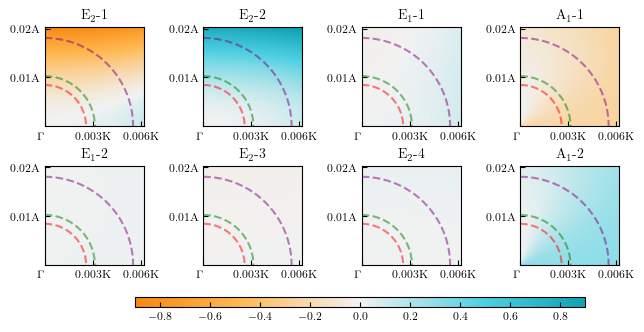

In [104]:
cmap = mcolors.LinearSegmentedColormap.from_list('light_amber_cyan_diverging', [[0, '#F57C00'], [0.25, '#FFB74D'], [0.5, '#F2F2F2'], [0.75, '#4DD0E1'], [1, '#0097A7']])
fig, axes = plt.subplots(2, 4, figsize=(7.5, 3.5))
for i, ax in enumerate(axes.flat):
  data = np.mean([(np.array(frequency[mode]) - frequency[mode][0][0]) / 3 * 100 for mode in negligible_polar_modes[i]], axis=0)
  im = ax.imshow(data, cmap=cmap, origin='lower', norm=mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1))
  ax.set_xlim(0, 100)
  ax.set_ylim(0, 100)
  ax.set_title(negligible_polar_name[i], fontsize=10)
  ax.set_xticks([0, 9.70 / 20 * 100, 19.40 / 20 * 100], labels=['$\\Gamma$', '0.003K', '0.006K'], fontsize=8)
  ax.set_yticks([9.88 / 20 * 100, 19.75 / 20 * 100], labels=['0.01A', '0.02A'], fontsize=8)
  ax.get_xticklabels()[0].set_horizontalalignment('right')
  ax.tick_params(axis='both', which='both', direction='in')
  for l in range(len(lazer_vec)):
    ax.plot(np.sin(np.linspace(0, np.pi / 2, 101)) * 100 / 20 * lazer_vec[l], np.cos(np.linspace(0, np.pi / 2, 101)) * 100 / 20 * lazer_vec[l], color=lazer_color[l], linestyle='--', alpha=0.5)
fig.subplots_adjust(bottom=0.2, hspace=0.4, wspace=0.5)
cbar_ax = fig.add_axes([0.25, 0.08, 0.60, 0.03])
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_xlim(-0.9, 0.9)
cbar_ax.tick_params(direction='in', labelsize=8)
# fig.tight_layout()
fig.show()
fig.savefig('画图/入射角度与偏移/nopo.svg', format='svg', transparent=True, bbox_inches='tight')

/tmp/ipykernel_2596786/2254584389.py:20: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



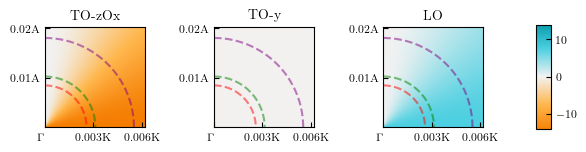

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(7.5, 1.3))
for i, ax in enumerate(axes):
  data = np.mean([(np.array(frequency[mode]) - frequency[mode][0][0]) / 3 * 100 for mode in strong_polar_modes[i]], axis=0)
  im = ax.imshow(data, cmap=cmap, origin='lower', norm=mcolors.TwoSlopeNorm(vmin=-15, vcenter=0, vmax=15))
  ax.set_xlim(0, 100)
  ax.set_ylim(0, 100)
  ax.set_title(strong_polar_name[i], fontsize=10)
  ax.set_xticks([0, 9.70 / 20 * 100, 19.40 / 20 * 100], labels=['$\\Gamma$', '0.003K', '0.006K'], fontsize=8)
  ax.set_yticks([9.88 / 20 * 100, 19.75 / 20 * 100], labels=['0.01A', '0.02A'], fontsize=8)
  ax.get_xticklabels()[0].set_horizontalalignment('right')
  ax.tick_params(axis='both', which='both', direction='in')
  for l in range(len(lazer_vec)):
    ax.plot(np.sin(np.linspace(0, np.pi / 2, 101)) * 100 / 20 * lazer_vec[l], np.cos(np.linspace(0, np.pi / 2, 101)) * 100 / 20 * lazer_vec[l], color=lazer_color[l], linestyle='--', alpha=0.5)
fig.subplots_adjust(right=0.75, hspace=0.3, wspace=0.3)
cbar_ax = fig.add_axes([0.8, 0.1, 0.02, 0.8])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylim(-14, 14)
cbar_ax.tick_params(direction='in', labelsize=8)
# fig.tight_layout()
fig.show()
fig.savefig('画图/入射角度与偏移/po.svg', format='svg', transparent=True, bbox_inches='tight')

In [ ]:
polarizations = [ "zyyz", "xyyx" ]
peek = [ "E21", "E22", "A11" ]
data = {peak: {p: np.loadtxt(f'画图/拉曼结果拟合/combined/substrate/{peak}_shift_{p}.txt') for p in polarizations} for peak in peek}
mean = {pe: {p: np.mean(data[pe][p]) for p in polarizations} for pe in peek}
std = {pe: {p: np.std(data[pe][p]) for p in polarizations} for pe in peek}
distribute_range = {pe: {p: np.linspace(mean[pe][p] - 5*std[pe][p], mean[pe][p] + 5*std[pe][p], 100) for p in polarizations} for pe in peek}
theoretical_result = { "E21": 0.263, "E22": 0.221, "A11": 0.188 }
color = { "zyyz": "#50cfd2", "xyyx": "#9d569c" }
peak_label = { "E21": "$\\mathrm{E_2}$-1", "E22": "$\\mathrm{E_2}$-2", "A11": "$\\mathrm{A_1}$-1" }

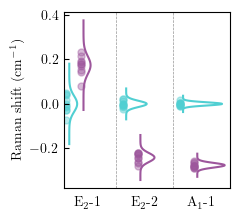

In [130]:
normal_dist = lambda x, mu, sigma: np.exp( - (x - mu)**2 / (2 * sigma**2) ) / 50 / sigma
fig, ax = plt.subplots(figsize=(2.5, 2.3))
for i, pe in enumerate(peek):
  for j, p in enumerate(polarizations):
    ax.scatter(np.ones_like(data[pe][p]) - 1 + j + i * 4, data[pe][p] - mean[pe]["zyyz"], color=color[p], alpha=0.4, s=25)
    ax.plot(normal_dist(distribute_range[pe][p] - mean[pe]["zyyz"], mean[pe][p] - mean[pe]["zyyz"], std[pe][p]) + j + 0.2 + i * 4, distribute_range[pe][p] - mean[pe]["zyyz"], color=color[p])
    # 加一条分割线
    ax.axvline(x=i * 4 - 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.tick_params(axis="y", direction='in', labelsize=10)
ax.tick_params(axis="x", bottom=False, labelsize=10)
ax.set_xticks([i * 4 + 1.5 for i in range(len(peek))])
ax.set_xticklabels([peak_label[pe] for pe in peek])
ax.set_xlim(-0.2, 11.5)
ax.set_ylabel('Raman shift (cm$^{-1}$)')
# ax.set_title('Experimental results', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show() 
fig.savefig(f'画图/入射角度与偏移/1.svg', format='svg', transparent=True, bbox_inches='tight')

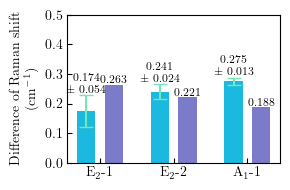

In [128]:
fig, ax = plt.subplots(figsize=(3, 2))
for i, peak in enumerate(peek):
  ax.bar(i * 0.8, abs(mean[peak]['zyyz'] - mean[peak]['xyyx']), width=0.2, color='#1bb8df')
  ax.errorbar(i * 0.8, abs(mean[peak]['zyyz'] - mean[peak]['xyyx']), yerr=np.sqrt(std[peak]['zyyz']**2 + std[peak]['xyyx']**2), capsize=5, color='#72e8b4')
  ax.text(i * 0.8, abs(mean[peak]['zyyz'] - mean[peak]['xyyx']) + np.sqrt(std[peak]['zyyz']**2 + std[peak]['xyyx']**2) + 0.01, f'{abs(mean[peak]["zyyz"] - mean[peak]["xyyx"]):.3f}\n$\\pm$ {np.sqrt(std[peak]['zyyz']**2 + std[peak]['xyyx']**2):.3f}', ha='center', fontsize=8)
  ax.bar(i * 0.8 + 0.3, theoretical_result[peak], width=0.2, color='#7b7bc9')
  ax.text(i * 0.8 + 0.3, theoretical_result[peak] + 0.005, f'{theoretical_result[peak]:.3f}', ha='center', fontsize=8)
ax.set_xticks([0.15, 0.95, 1.75])
ax.set_xticklabels([peak_label[peak] for peak in peek])
ax.set_ylabel('Difference of Raman shift\n(cm$^{-1}$)')
ax.set_ylim(0, 0.5)
ax.tick_params(direction='in')
# ax.set_title('Experimental v.s. calculated', fontsize=10, x=0.35)
plt.tight_layout()
plt.show()
fig.savefig(f'画图/入射角度与偏移/2.svg', format='svg', transparent=True, bbox_inches='tight')